In [1]:
import sys,os
from pathlib import Path
sys.path.append(str(Path("../")))
import torch
from torch.autograd import Variable
from torchvision import transforms as ts
from utils import loaders
import numpy as np

In [2]:
import PIL.Image as Image

In [3]:
label_path="../data/anime/train_label/img_1_0_keypoints.json"
G_body=torch.load("../model_openpose/netGbody_struct.pth").cuda()
G_body.load_state_dict(torch.load("../model_openpose/netGbody_run460.pt"))
G_face=torch.load("../model_openpose/netGface_struct.pth").cuda()
G_face.load_state_dict(torch.load("../model_openpose/netGface_run370.pt"))
lbl_sample,head_mtx,head_center = loaders.read_label(label_path,ifhead=True,ifbody=True)

tensor(1.) tensor(-0.9216)


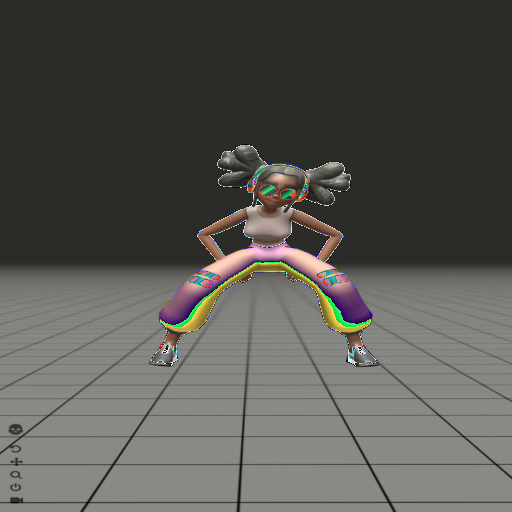

In [3]:
A=loaders.pil_loader("../data/girl/train_img/157_60.jpg")
body=loaders.transform_dict["body"](A)
print(body.max(),body.min())
ts.ToPILImage()(body)

In [25]:
def to_4d(inp):
    return np.expand_dims(inp,0)
HALF_HEAD=loaders.HEAD_SIZE//2
def patch_head(body_img,head_img,head_center):
    img=body_img.detach().cpu()
    img[:,:,head_center[1]-HALF_HEAD:head_center[1]+HALF_HEAD,head_center[0]-HALF_HEAD:head_center[0]+HALF_HEAD]\
    =head_img
    return np.squeeze(img)

In [4]:
with torch.no_grad():
    body_img=G_body(torch.tensor(to_4d(lbl_sample), device=torch.device('cuda:0')))

In [5]:
head_in=loaders.transform_dict["head"](\
        ts.ToPILImage()(body_img[:,:,head_center[1]-HALF_HEAD:head_center[1]+HALF_HEAD,head_center[0]-HALF_HEAD:head_center[0]+HALF_HEAD].detach().squeeze(0).cpu()))

In [11]:
with torch.no_grad():
    head_lbl=torch.tensor(to_4d(head_mtx),dtype=torch.float32, device=torch.device('cuda:0'))
    fake_head=torch.tensor(to_4d(head_in),dtype=torch.float32, device=torch.device('cuda:0'))
    head_input=torch.cat((fake_head, head_lbl), dim=1)
    head_buff=G_face(head_input)
    head_enhance=head_buff+fake_head

In [45]:
head_enhance=head_buff*0.7+fake_head*0.7

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


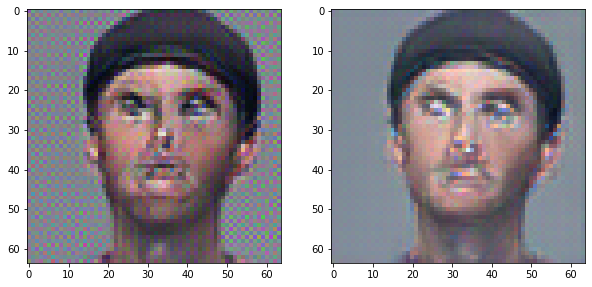

In [46]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(torch.squeeze(body_img[:,:,head_center[1]-HALF_HEAD:head_center[1]+HALF_HEAD,head_center[0]-HALF_HEAD:head_center[0]+HALF_HEAD],0).detach().type(torch.float32).cpu().numpy().transpose(1,2,0))
plt.subplot(1,2,2)
plt.imshow(head_enhance[0,...].detach().type(torch.float32).cpu().numpy().transpose(1,2,0))

In [26]:
img_=patch_head(body_img,head_enhance,head_center)

In [12]:
head_out.shape

torch.Size([1, 3, 64, 64])

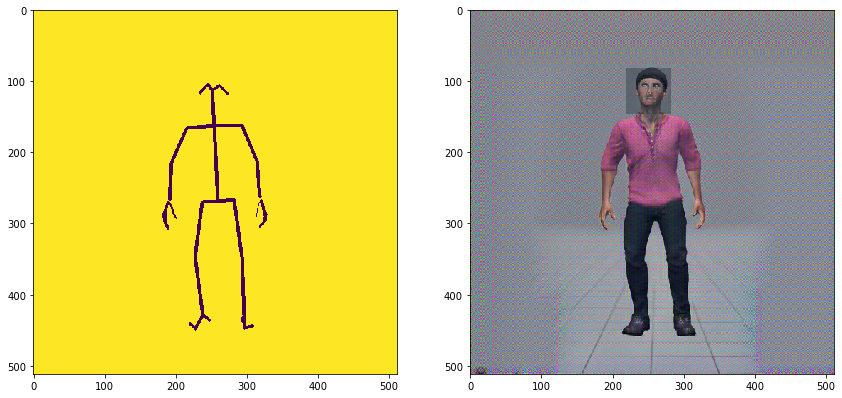

In [39]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30,30))
plt.subplot(1,4,1)
plt.imshow(lbl_sample[34,...])
plt.subplot(1,4,2)
plt.imshow(img_[...].detach().type(torch.float32).cpu().numpy().transpose(1,2,0))

In [41]:
img_pil=ts.ToPILImage()(torch.squeeze(img_,0))

In [42]:
img_pil.save("../cat_head_body.png")